# Python Learn by Doing: ENSO, Your Turn! Option 1 Answer Key

**Developed By:** Dr. Kerrie Geil, Mississippi State University

**Original Development Date:** August 2024

**Package Requirements:** xarray, netcdf4, numpy, pandas, scipy, matplotlib, cartopy, jupyter

**Links:** **[OSF project link](https://osf.io/zhpd5/)**, [link to this notebook on github](https://github.com/kerriegeil/MSU_py_training/blob/main/learn_by_doing/enso/assignments/enso_analysis_option1.ipynb)

---
**Assignment:**

Repeat science question 3 using October-March for the winter months. 

1) What do you notice about the spatial pattern of where positive and negative composite anomalies occur in the DJF vs ONDJFM plots? Do the figures appear very similar or very different?

Plot difference maps of DJF results minus ONDJFM results (temperature and precipitation for both El Nino and La Nina).

2) What do the colors on the difference maps mean?
3) What else could we plot to better understand how different the results are for DJF vs ONDJFM? 

Make additional figures to answer the following questions for El Nino and La Nina temperature and precipitation.

4) Does the sign (i.e. negative, positive) of the composite anomaly change in the DJF versus ONDJFM results in any areas that are statistically significant in both DJF and ONDJFM? 
5) For our analysis, is there a major difference between using ONDJFM as opposed to DJF to calculate El Nino- and La Nina-related composite anomalies in temperature and precipitation?



&emsp;**Hints:**
- From enso_analysis.ipynb, copy the appropriate data cleaning steps to create the arrays for the nino index `nino`, t anomaly `t_anom` and pr anomaly `pr_anom`
- From enso_analysis.ipynb, copy the appropriate analysis steps from science question 1 to create the array `nino_events` 
- From enso_analysis.ipynb, copy the appropriate analysis steps from science question 3 to create the arrays `t_nino_DJF_composite`, `t_nino_DJF_pval`,`pr_nino_DJF_composite`, `pr_nino_DJF_pval` as well as similar arrays for La Nina. 
    - Modify this line `t_nino_DJF=t_nino.groupby(t_nino.time.dt.season)['DJF']` using a list of month integers instead of a season string. (Use .sel instead of .groupby as well as .time.dt.month.isin() to select the months)   
    - Consider creating a function for this part of the analysis to cut down on repeated code. The function would:
        - take inputs `nino_events`, the anomaly data, enso phase (as a string or integer), and list of month intergers
        - return the composite and p values
- Repeat the previous step with October-March instead of December-February to generate the arrays `t_nino_ONDJFM_composite`, `t_nino_ONDJFM_pval`,`pr_nino_ONDJFM_composite`, `pr_nino_ONDJFM_pval` as well as similar arrays for La Nina.
- Make a figure with 3 rows and 2 columns of plots showing 
    1) `t_nino_DJF_composite` masked with `t_nino_DJF_pval` at pval<=0.1,
    2) `pr_nino_DJF_composite` masked with `pr_nino_DJF_pval` at pval<=0.1, 
    3) `t_nino_ONDJFM_composite` masked with `t_nino_ONDJFM_pval` at pval<=0.1, 
    4) `pr_nino_ONDJFM_composite` masked with `pr_nino_ONDJFM_pval` at pval<=0.1,
    5) `t_nino_DJF_composite` minus `t_nino_ONDJFM_composite`,
    6) `pr_nino_DJF_composite` minus `pr_nino_ONDJFM_composite`
- Make a similar figure as the previous step for La Nina 
- Answer the first 3 questions of the exercise
- One way to find areas where the sign of the composite changes between the DJF vs ONDJFM results (positive to negative or vice versa) is to:
    - mask the DJF and ONDJFM composites with their p values
    - change the composite values where negative to -1 and where positive to +1
    - add them together. You will get 0 where the sign of the composite value changes, otherwise you will have -2 or +2. 
- Make a figure showing the areas of -2, 0, and +2 from the previous step to see where the sign of the anomaly changes and where it doesn't. And answer the final two questions using this figure.

# Packages and file names


In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy.stats as ss

import os
import sys

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

In [4]:
# files we've already downloaded
nino_f = '../data/nino34_anomalies_monthly_NOAA.txt'
sst_f = '../data/sst_monthly_COBE2_JMA.nc'
t_f = '../data/tavg_monthly_BerkeleyEarth.nc'
pr_f = '../data/precip_monthly_PRECL_NOAA.nc'

# Data Cleaning

In [5]:
# data cleaning copied from enso_analysis.ipynb

year_start = '1948'
year_end = '2023'
base_start = '1981'
base_end = '2010'

# Nino3.4 index
nino_raw=pd.read_csv(nino_f,sep=r'\s+',skiprows=1,skipfooter=7,header=None,index_col=0,na_values=-99.99,engine='python')
nino=nino_raw.to_numpy().flatten()
dates=pd.date_range('1870-01-01','2024-12-01',freq='MS')
nino=xr.DataArray(nino,name='nino',dims='time',coords={'time':dates})
nino.attrs['standard_name']='nino3.4 index'
nino.attrs['units']='C'
nino=nino.sel(time=slice(year_start,year_end))

# precipitation data
ds=xr.open_dataset(pr_f)
pr=ds.precip
pr=pr.sel(time=slice(year_start,year_end))
pr=pr.reindex(lat=pr.lat[::-1])
pr.coords['lon']=xr.where(pr.coords['lon']>180,pr.coords['lon']-360,pr.coords['lon'])
roll_len=len(pr.lon)//2
pr=pr.roll(lon=roll_len,roll_coords=True)
pr_base=pr.sel(time=slice(base_start,base_end)) 
pr_clim=pr_base.groupby(pr_base.time.dt.month).mean('time') 
pr_anom=pr.groupby(pr.time.dt.month) - pr_clim  
pr_anom.attrs['standard_name']='pr anomaly'
pr_anom.attrs['units']='mm/day'

# temperature data
ds=xr.open_dataset(t_f)
dates=pd.date_range('1750-01-01','2024-03-01',freq='MS')
ds['time']=dates
ds=ds.rename({'month_number':'month','latitude':'lat','longitude':'lon'})
t_anom_5180=ds.temperature
clim_5180=ds.climatology
t=t_anom_5180.groupby(t_anom_5180.time.dt.month)+clim_5180
t_base=t.sel(time=slice(base_start,base_end))  
clim_8110 = t_base.groupby(t_base.time.dt.month).mean('time')  
t_anom=t.groupby(t.time.dt.month)-clim_8110
t_anom=t_anom.sel(time=slice(year_start,year_end))
t_anom=t_anom.rename('tavg')
t_anom.attrs['standard_name']='T anomaly'
t_anom.attrs['units']='C'

# check first and last time is the same for all data
variables=[nino, pr_anom, t_anom]
for var in variables:
    print(var.name, var.time[0].data,var.time[-1].data)

# clean up
del nino_raw, dates, ds, pr, pr_base, pr_clim, t, t_anom_5180, clim_5180, t_base, clim_8110, variables

nino 1948-01-01T00:00:00.000000000 2023-12-01T00:00:00.000000000
precip 1948-01-01T00:00:00.000000000 2023-12-01T00:00:00.000000000
tavg 1948-01-01T00:00:00.000000000 2023-12-01T00:00:00.000000000


# Begin Main Analysis

First, we need to know when El Nino and La Nina events occurred so we'll copy over code from question 1 in enso_analysis.ipynb (How many strong El Nino and La Nina events have occurred from 1948 to 2023?). We only need the part of the code that creates the array `nino_events` 

In [6]:
# copied from question 1 in enso_analysis.ipynb

# constants based on our criteria
nmonths=5
event_thresh=0.6

# first calculate the 5-month rolling mean
nino_rollmean=nino.rolling(time=nmonths,center=True).mean()

# create an array to hold our results and initialize to nan
# this array is where we will fill values with +1,-1
nino_events=nino_rollmean.copy() 
nino_events[:]=np.nan

# now loop through months and fill +1, -1 for windows of 5 months that meet our criteria
for i,value in enumerate(nino_rollmean):
    # La Nina conditions
    if  value < -event_thresh:
        
        # possible La Nina conditions, look forward 4 more months
        window=nino_rollmean[i:i+nmonths]
        if all(window < -event_thresh):
            nino_events[i:i+nmonths] = -1

    # El Nino conditions
    if  value > event_thresh:
        # possible El Nino conditions, look forward 4 more months
        window=nino_rollmean[i:i+nmonths]
        if all(window > event_thresh):
            nino_events[i:i+nmonths]=1    

Next, we need to build our composites and determine statistical significance. We'll copy over the relevant code from question 3 in enso_analysis.ipynb into a new function called `composite_and_pval` since we'll be running the same computation multiple times.

In [7]:
# a function to compute composites and pvals for different seasons
def composite_and_pval(nino_events,anom,phase,month_int_list):
    ''' 
    inputs
    nino_events :: the nino_events array of -1,+1 that we created in the previous step
    anom :: the temperature or precipitation anomaly data that we prepared in the data cleaning section
    phase :: string, either 'nino' or 'nina'
    month_int_list :: list of integers, months to include in the composite
    
    returns
    var_phase_composite :: the data composite for the appropriate enso phase and season
    var_pval :: the pvalues from a t-test for differences in means between samples of 
                phase months (nino or nina) in the requested season (month_int_list) and 
                non-phase months in the requested season
    '''
    if phase=='nino':
        phase_int=1
    elif phase=='nina':
        phase_int=-1
    else:
        sys.exit('phase can only be nino or nina')

    print(f'computing a {phase} composite for {anom.name} months {month_int_list}...')

    # composite for the approprate enso phase and season
    var_phase=anom.where(nino_events==phase_int,drop=True)
    var_phase_season=var_phase.sel(time=var_phase.time.dt.month.isin(month_int_list)) # sample 1
    var_phase_composite=var_phase_season.mean('time',keep_attrs=True)

    # sample 2 for t-test
    var_other = anom.where(nino_events!=phase_int,drop=True)
    var_other_season = var_other.sel(time=var_other.time.dt.month.isin(month_int_list))

    print(f'{anom.name} {phase} and non-{phase} sample sizes:',var_phase_season.shape[0],var_other_season.shape[0]) 
    
    # significance test
    var_sigtest = ss.ttest_ind(var_phase_season, var_other_season, axis=0, equal_var=False)
    var_pval = xr.DataArray(var_sigtest.pvalue, coords={'lat':('lat',var_phase.coords['lat'].data),'lon':('lon',var_phase.coords['lon'].data)})

    return var_phase_composite,var_pval

Now we calculate the following composites with pvalues:
- el nino temperature anomaly for DJF
- el nino temperature anomaly for ONDJFM
- el nino precipitation anomaly for DJF
- el nino precipitation anomaly for ONDJFM

In [8]:
t_nino_DJF_composite, t_nino_DJF_pval = composite_and_pval(nino_events,
                                                           t_anom,
                                                           phase='nino',
                                                           month_int_list=[12,1,2])

t_nino_ONDJFM_composite, t_nino_ONDJFM_pval = composite_and_pval(nino_events,
                                                                 t_anom,
                                                                 phase='nino',
                                                                 month_int_list=[10,11,12,1,2,3])

pr_nino_DJF_composite, pr_nino_DJF_pval = composite_and_pval(nino_events,
                                                           pr_anom,
                                                           phase='nino',
                                                           month_int_list=[12,1,2])

pr_nino_ONDJFM_composite, pr_nino_ONDJFM_pval = composite_and_pval(nino_events,
                                                                 pr_anom,
                                                                 phase='nino',
                                                                 month_int_list=[10,11,12,1,2,3])

computing a nino composite for tavg months [12, 1, 2]...
tavg nino and non-nino sample sizes: 44 184
computing a nino composite for tavg months [10, 11, 12, 1, 2, 3]...
tavg nino and non-nino sample sizes: 86 370
computing a nino composite for precip months [12, 1, 2]...
precip nino and non-nino sample sizes: 44 184
computing a nino composite for precip months [10, 11, 12, 1, 2, 3]...
precip nino and non-nino sample sizes: 86 370


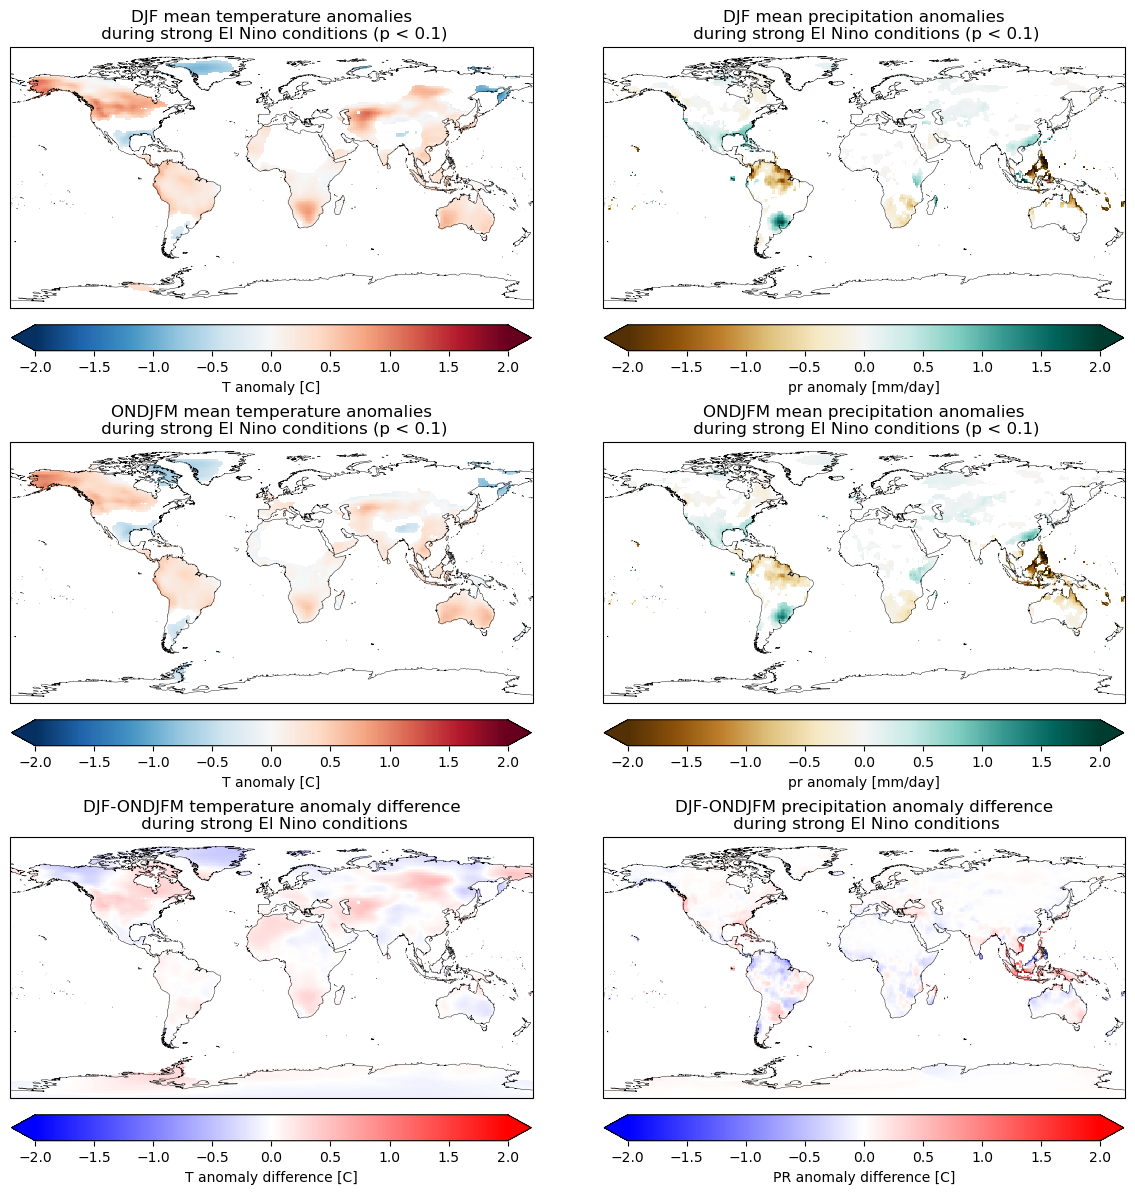

In [9]:
# make plots using pval < 0.1
pval=0.1

fig=plt.figure(figsize=(12,12))

# DJF plots
ax=fig.add_subplot(321,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
t_nino_DJF_composite.where(t_nino_DJF_pval<pval).plot(vmin=-2, vmax=2, extend='both',cmap='RdBu_r',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})
plt.title(f'DJF mean temperature anomalies\n during strong El Nino conditions (p < {pval})')

ax=fig.add_subplot(322,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
pr_nino_DJF_composite.where(pr_nino_DJF_pval<pval).plot(vmin=-2, vmax=2, extend='both',cmap='BrBG',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})
plt.title(f'DJF mean precipitation anomalies\n during strong El Nino conditions (p < {pval})')

# ONDJFM plots
ax=fig.add_subplot(323,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
t_nino_ONDJFM_composite.where(t_nino_ONDJFM_pval<pval).plot(vmin=-2, vmax=2, extend='both',cmap='RdBu_r',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})
plt.title(f'ONDJFM mean temperature anomalies\n during strong El Nino conditions (p < {pval})')

ax=fig.add_subplot(324,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
pr_nino_ONDJFM_composite.where(pr_nino_ONDJFM_pval<pval).plot(vmin=-2, vmax=2, extend='both',cmap='BrBG',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})
plt.title(f'ONDJFM mean precipitation anomalies\n during strong El Nino conditions (p < {pval})')

# difference plots
ax=fig.add_subplot(325,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
(t_nino_DJF_composite-t_nino_ONDJFM_composite).plot(vmin=-2, vmax=2,extend='both',cmap='bwr',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05,'label':'T anomaly difference [C]'})
plt.title(f'DJF-ONDJFM temperature anomaly difference\n during strong El Nino conditions')

ax=fig.add_subplot(326,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
(pr_nino_DJF_composite-pr_nino_ONDJFM_composite).plot(vmin=-2, vmax=2,extend='both',cmap='bwr',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05,'label':'PR anomaly difference [C]'})
plt.title(f'DJF-ONDJFM precipitation anomaly difference\n during strong El Nino conditions')

plt.tight_layout()
plt.show()

repeat for La Nina

In [10]:
t_nina_DJF_composite, t_nina_DJF_pval = composite_and_pval(nino_events,
                                                           t_anom,
                                                           'nina',
                                                           [12,1,2])

t_nina_ONDJFM_composite, t_nina_ONDJFM_pval = composite_and_pval(nino_events,
                                                                 t_anom,
                                                                 'nina',
                                                                 [10,11,12,1,2,3])

pr_nina_DJF_composite, pr_nina_DJF_pval = composite_and_pval(nino_events,
                                                           pr_anom,
                                                           'nina',
                                                           [12,1,2])

pr_nina_ONDJFM_composite, pr_nina_ONDJFM_pval = composite_and_pval(nino_events,
                                                                 pr_anom,
                                                                 'nina',
                                                                 [10,11,12,1,2,3])

computing a nina composite for tavg months [12, 1, 2]...
tavg nina and non-nina sample sizes: 59 169
computing a nina composite for tavg months [10, 11, 12, 1, 2, 3]...
tavg nina and non-nina sample sizes: 118 338
computing a nina composite for precip months [12, 1, 2]...
precip nina and non-nina sample sizes: 59 169
computing a nina composite for precip months [10, 11, 12, 1, 2, 3]...
precip nina and non-nina sample sizes: 118 338


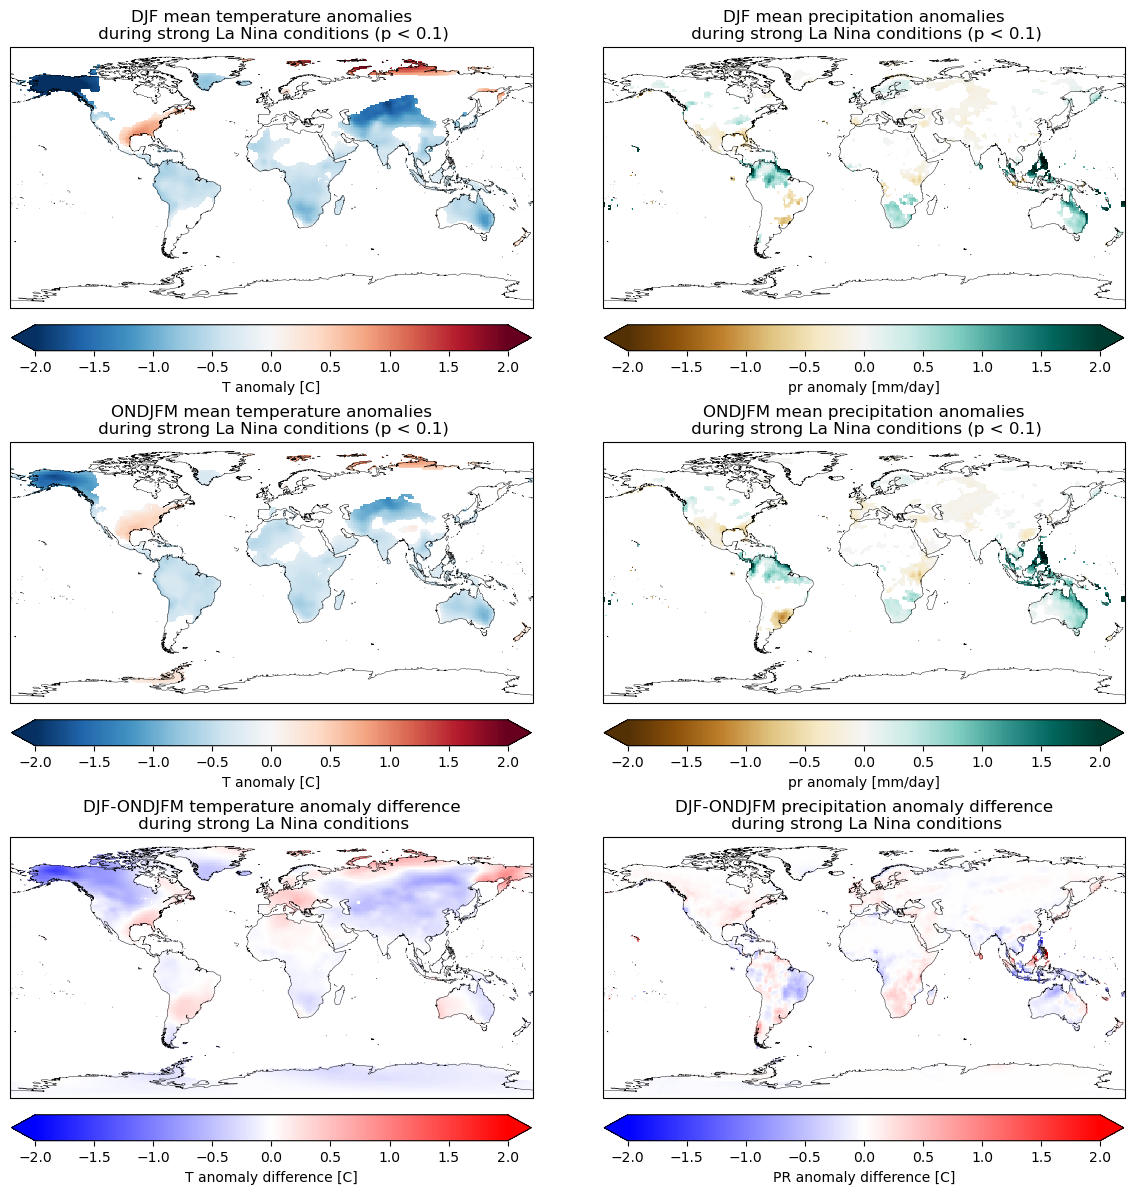

In [11]:
# make plots using pval < 0.1
pval=0.1

fig=plt.figure(figsize=(12,12))

# DJF plots
ax=fig.add_subplot(321,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
t_nina_DJF_composite.where(t_nina_DJF_pval<pval).plot(vmin=-2, vmax=2, extend='both',cmap='RdBu_r',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})
plt.title(f'DJF mean temperature anomalies\n during strong La Nina conditions (p < {pval})')

ax=fig.add_subplot(322,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
pr_nina_DJF_composite.where(pr_nina_DJF_pval<pval).plot(vmin=-2, vmax=2, extend='both',cmap='BrBG',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})
plt.title(f'DJF mean precipitation anomalies\n during strong La Nina conditions (p < {pval})')

# ONDJFM plots
ax=fig.add_subplot(323,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
t_nina_ONDJFM_composite.where(t_nina_ONDJFM_pval<pval).plot(vmin=-2, vmax=2, extend='both',cmap='RdBu_r',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})
plt.title(f'ONDJFM mean temperature anomalies\n during strong La Nina conditions (p < {pval})')

ax=fig.add_subplot(324,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
pr_nina_ONDJFM_composite.where(pr_nina_ONDJFM_pval<pval).plot(vmin=-2, vmax=2, extend='both',cmap='BrBG',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})
plt.title(f'ONDJFM mean precipitation anomalies\n during strong La Nina conditions (p < {pval})')

# difference plots
ax=fig.add_subplot(325,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
(t_nina_DJF_composite-t_nina_ONDJFM_composite).plot(vmin=-2, vmax=2,extend='both',cmap='bwr',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05,'label':'T anomaly difference [C]'})
plt.title(f'DJF-ONDJFM temperature anomaly difference\n during strong La Nina conditions')

ax=fig.add_subplot(326,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
(pr_nina_DJF_composite-pr_nina_ONDJFM_composite).plot(vmin=-2, vmax=2,extend='both',cmap='bwr',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05,'label':'PR anomaly difference [C]'})
plt.title(f'DJF-ONDJFM precipitation anomaly difference\n during strong La Nina conditions')

plt.tight_layout()
plt.show()

### What do you notice about the spatial pattern of where positive and negative composite anomalies occur in the DJF vs ONDJFM plots? Do the figures appear very similar or very different?
We can see that the spatial patterns of temperature and precipitation anomalies during strong El Nino and La Nina events in boreal cool months is robust. There is not much difference in the location of where anomalies occur due to the choice of using DJF or ONDJFM.

### What do the colors on the difference maps mean?

Personally, I find these types of difference maps a bit confusing because for example, a blue area on this difference map can mean 3 things: 
1) the area has a negative anomaly for DJF and a less negative anomaly for ONDJFM (like Alaska La Nina temperature), 
2) the area has a negative anomaly for DJF and a positive anomaly of lesser magnitude for ONDJFM (I don't see any areas on our figures to give as an example but it could be happening in the masked out grid cells), or 
3) the area has a positive anomaly for DJF and a larger positive anomaly for ONDJFM (like eastern Australia El Nino temperature). 

The situation is similar for the red areas on these difference maps. That's too much to think about simultaneously. 

### What else could we plot to better understand how different the results are for DJF vs ONDJFM?

One way to see where the results are very different is to determine whether the sign of the composite anomaly changes in the DJF vs ONDJFM results. E.g. El Nino DJF temperature anomaly is negative in a particular area but El Nino ONDJFM temperature anomaly is positive for that same area. Of course, this switch in sign can be more likely to happen in areas that are not statistically significant. But we could mask out where both DJF and ONDJFM anomalies are not significant to aid in our interpretation.

Let's take a look.

In [41]:
# a function to find where the sign of the anomaly changes
def anom_sign_change(anom_DJF,pval_DJF,anom_ONDJFM,pval_ONDJFM,sig_lvl):
    ''' 
    inputs
    anom_DJF :: the nino or nina temperature or precipitation anomaly composite for DJF
    anom_ONDJFM :: the nino or nina temperature or precipitation anomaly composite for ONDJFM
    pval_DJF :: the nino or nina temperature or precipitation anomaly composite pvalues for DJF
    pval_ONDJFM :: the nino or nina temperature or precipitation anomaly composite pvalues for ONDJFM
    sig_lvl :: the pvalue that is considered statistically significant
    
    returns
    anom_sign_change :: an array with three possible values indicating how the sign of the anomaly 
                        changes between the results for DJF and ONDJFM. This array is masked to 
                        only show grid cells that are statistically significant in both the DJF
                        and ONDJFM composite pvalues 
                        0 --> the sign of the anomaly flip flops
                        -2 --> the sign of the anomaly is always negative
                        +2 --> the sign of the anomaly is always positive
    '''
    # mask anomalies to only statistically significant 
    # grid cells (fills nan where False)
    anom_DJF = anom_DJF.where(pval_DJF<=sig_lvl)          
    anom_ONDJFM = anom_ONDJFM.where(pval_ONDJFM<=sig_lvl)

    # arrays where negative anomalies --> -1, positive anomalies --> +1
    anom_DJF_posneg = xr.where(anom_DJF>=0,1,anom_DJF)
    anom_DJF_posneg = xr.where(anom_DJF<0,-1,anom_DJF_posneg)
   
    anom_ONDJFM_posneg = xr.where(anom_ONDJFM>=0,1,anom_ONDJFM)
    anom_ONDJFM_posneg = xr.where(anom_ONDJFM<0,-1,anom_ONDJFM_posneg)

    # an array with three possible values (as well as nans) indicating how 
    # the sign of the anomaly changes between the results for DJF and ONDJFM
    anom_sign_change = anom_DJF_posneg + anom_ONDJFM_posneg  # note nan math here

    return anom_sign_change

In [42]:
# call the function

pval=0.1
t_nino_sign_change = anom_sign_change(t_nino_DJF_composite,t_nino_DJF_pval,t_nino_ONDJFM_composite,t_nino_ONDJFM_pval,pval)
pr_nino_sign_change = anom_sign_change(pr_nino_DJF_composite,pr_nino_DJF_pval,pr_nino_ONDJFM_composite,pr_nino_ONDJFM_pval,pval)

t_nina_sign_change = anom_sign_change(t_nina_DJF_composite,t_nina_DJF_pval,t_nina_ONDJFM_composite,t_nina_ONDJFM_pval,pval)
pr_nina_sign_change = anom_sign_change(pr_nina_DJF_composite,pr_nina_DJF_pval,pr_nina_ONDJFM_composite,pr_nina_ONDJFM_pval,pval)

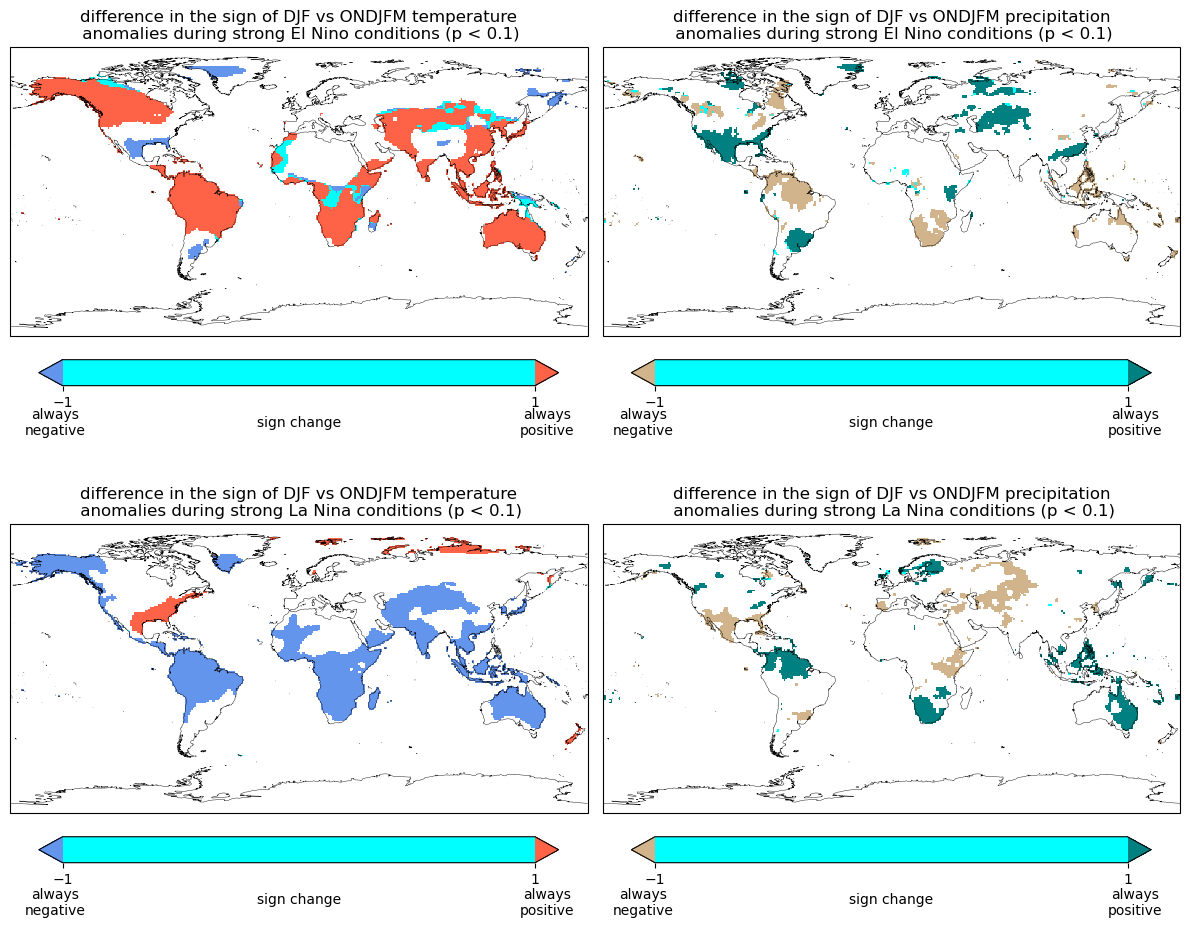

In [43]:
# plot results

fig=plt.figure(figsize=(12,10))

t_colors=['cornflowerblue','cyan','tomato']
pr_colors=['tan','cyan','teal']
levels=[-1,1]

ax=fig.add_subplot(221,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
t_nino_sign_change.plot(levels=levels,colors=t_colors, cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05,'label':'sign change'})#,'ticks':['a','b']})#['always\nnegative','always\npositive']})
plt.title(f'difference in the sign of DJF vs ONDJFM temperature\n anomalies during strong El Nino conditions (p < {pval})')
fig.text(.05,.5,'always\nnegative',ha='center')
fig.text(.46,.5,'always\npositive',ha='center')

ax=fig.add_subplot(222,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
pr_nino_sign_change.plot(levels=levels,colors=pr_colors, cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05,'label':'sign change'})
plt.title(f'difference in the sign of DJF vs ONDJFM precipitation\n anomalies during strong El Nino conditions (p < {pval})')
fig.text(.54,.5,'always\nnegative',ha='center')
fig.text(.95,.5,'always\npositive',ha='center')

ax=fig.add_subplot(223,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
t_nina_sign_change.plot(levels=levels,colors=t_colors, cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05,'label':'sign change'})
plt.title(f'difference in the sign of DJF vs ONDJFM temperature\n anomalies during strong La Nina conditions (p < {pval})')
fig.text(.05,.02,'always\nnegative',ha='center')
fig.text(.46,.02,'always\npositive',ha='center')

ax=fig.add_subplot(224,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
pr_nina_sign_change.plot(levels=levels,colors=pr_colors, cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05,'label':'sign change'})
plt.title(f'difference in the sign of DJF vs ONDJFM precipitation\n anomalies during strong La Nina conditions (p < {pval})')
fig.text(.54,.02,'always\nnegative',ha='center')
fig.text(.95,.02,'always\npositive',ha='center')

plt.tight_layout()
plt.show()

### Does the sign (i.e. negative, positive) of the composite anomaly change in the DJF versus ONDJFM results in any areas that are statistically significant in both DJF and ONDJFM?

We can see statistcally significant areas where the sign of the composite anomaly changes colored in cyan in the figures above. El Nino precipitation, La Nina precipitation, and La Nina temperature anomalies almost never change from positive to negative or vice versa depending on whether we use the DJF or ONDJFM months to calculate the anomalies. The figure of El Nino temperature anomalies is the only figure above showing large-ish areas where the anomaly switches sign from positive to negative or vice versa when we calculate the composite anomalies using the DJF vs ONDJFM months.

### For our analysis, is there a major difference between using ONDJFM as opposed to DJF to calculate El Nino- and La Nina-related composite anomalies in temperature and precipitation?

If we look at where the cyan color occurs in the El Nino temperature anomaly figure above, we can see that it is always along the edges of a red or blue area or in a transition area between red and blue. If you scroll back up a few plots to the EL Nino mean temperature anomaly figures for both DJF and ONDJFM, we can also see that the cyan areas correspond to areas on these maps with lower magnitude anomalies. The plot below shows the cyan areas side by side with the anomaly values for the cyan areas only. 

Remember that the spatial pattern of El Nino temperature anomalies will look slightly different each month of the year. So in these area of low magnitude anomalies, changing the months used to calculate the anomalies can change the results. We can see clearly in the figure below that none of the cyan areas occur in locations with major ENSO-related temperature anomalies and for that reason we can say that, at least for our analysis, it does not make much difference whether we use the months DJF or ONDJFM- the areas of major ENSO-related temperature and precipitation anomalies are remarkably similar.

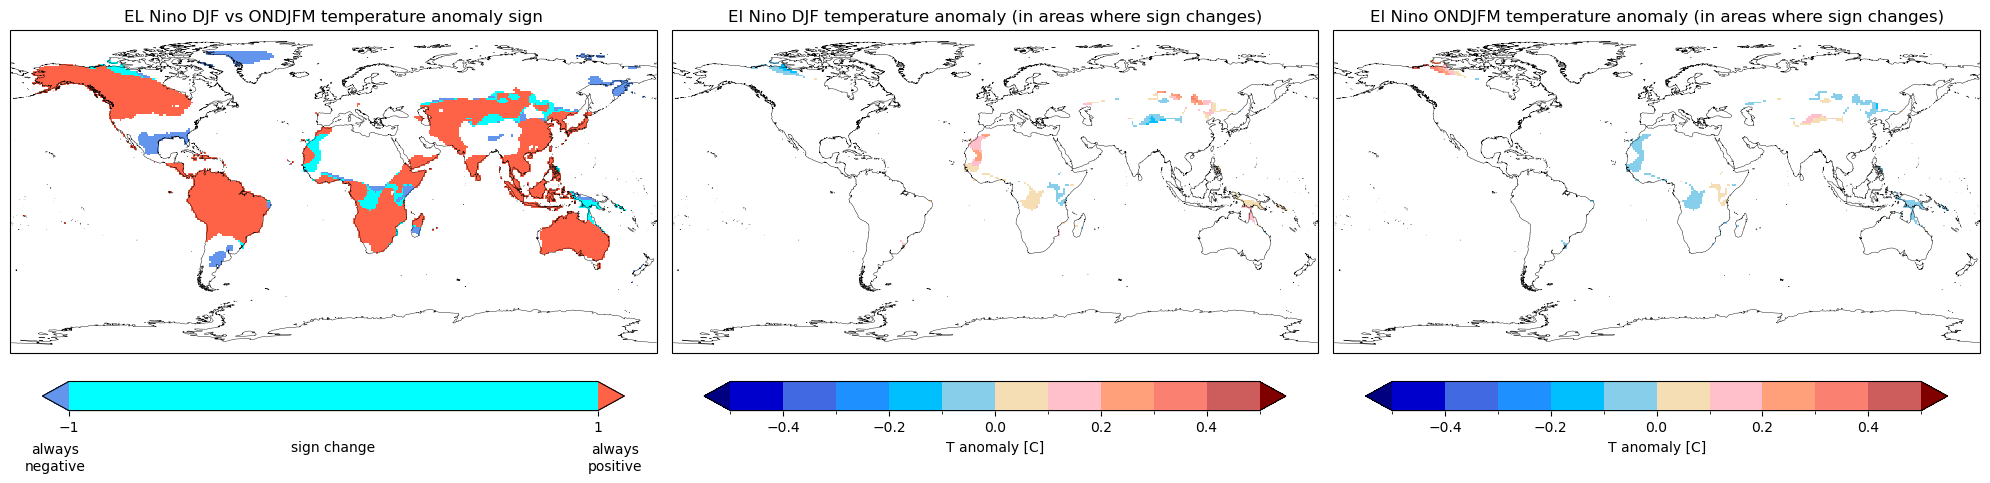

In [56]:
fig=plt.figure(figsize=(20,6))

ax=fig.add_subplot(131,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
t_nino_sign_change.plot(levels=levels,colors=t_colors, cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05,'label':'sign change'})#,'ticks':['a','b']})#['always\nnegative','always\npositive']})
plt.title(f'EL Nino DJF vs ONDJFM temperature anomaly sign')
fig.text(.03,.02,'always\nnegative',ha='center')
fig.text(.31,.02,'always\npositive',ha='center')

anom_levels=[-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5]
anom_colors=['navy','mediumblue','royalblue','dodgerblue','deepskyblue','skyblue','wheat','pink','lightsalmon','salmon','indianred','maroon']

ax=fig.add_subplot(132,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
t_nino_DJF_composite.where(t_nino_sign_change==0).plot(levels=anom_levels,colors=anom_colors,extend='both',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})#,'label':'sign change'})#,'ticks':['a','b']})#['always\nnegative','always\npositive']})
plt.title(f'El Nino DJF temperature anomaly (in areas where sign changes)')

ax=fig.add_subplot(133,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
t_nino_ONDJFM_composite.where(t_nino_sign_change==0).plot(levels=anom_levels,colors=anom_colors,extend='both',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})#,'label':'sign change'})#,'ticks':['a','b']})#['always\nnegative','always\npositive']})
plt.title(f'El Nino ONDJFM temperature anomaly (in areas where sign changes)')


plt.tight_layout()
plt.show()